# LTSDiff research

For this research an implementation is created of the [LTSDiff](https://dl.acm.org/doi/pdf/10.1145/2430545.2430549) algorithm. This implementation is created in Python and can use different SMT-solvers. With these solvers the global simualrity score can be calculated. Since every solver has a different implementation, the execution speed of the solvers can be different. In this small research we will look into the different SMT-solvers that the Python code can use and also a small case study on the evolution of a system.\
These topics are divided over the following research questions:
- RQ1: Do SMT solvers scale in the state-based comparison of real-world models?
- RQ2: Is one SMT solver superior to the other solvers?
- RQ3: Does the runtime of the solvers correlate to the size of the model changes?
- RQ4: How does the difference between models change during the evolution of a system?

To answer these questions three datasets were used:
- TCP server models
- SSH implementation models
- openSSL version models

Here all TCP server models were compared using the LTSDiff algorithm against itself and all other server models. The same holds for the SSH models. But for the openSSL, only the distinct models were ran agains itself and all other models. This was due to the fact that there was not enough time to run all the openSSL models against each other.\
After the LTSDiff algorithm was run on the openSSL models, a release date was searched. These release dates were retrieved from the [openSSL GitHub](https://github.com/openssl/openssl) and added to the LTSDiff output file.\

Every execution was done using all of the four SMT-solvers:
- z3
- yices
- cvc4
- msat

This means that one comparison of the LTSDiff algorithm was at leas executed four times. Here every execution a different SMT-solver was used and the time of the SMT-part was saved.\
\
All these data is then loaded in to one csv-file. This csv-file then contains the essential information of every execution of the LTSDiff algorithm.

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import datetime
from math import sqrt
from scipy import stats

In [80]:
openssl_dataframe = pandas.read_csv('../openssl_files/results_distinct.csv')
ssh_dataframe = pandas.read_csv('../result_files/results_ssh.csv')
tcp_dataframe = pandas.read_csv('../result_files/results_tcp.csv')
tcp_dataframe = tcp_dataframe[tcp_dataframe["iteration"] < 4]

big_dataframe = pandas.concat([openssl_dataframe, ssh_dataframe, tcp_dataframe], join='inner')

## RQ1: Do SMT solvers scale in the state-based comparison of real-world models?

To answer this questions we take all the outcomes we have and check if some execution time is higher then a certain number of hours, which is not doable any more in the real-world. For this time we set this time limit to 6 hours. Below we can see that two solvers were not able to come with a solution for every case.

,reference version,updated version,total hours,SMT solver
19,TCP_FreeBSD_Server,TCP_Linux_Server,12.440584,msat
20,TCP_FreeBSD_Server,TCP_Linux_Server,9.002594,msat
21,TCP_FreeBSD_Server,TCP_Linux_Server,19.765870,msat
12,TCP_FreeBSD_Server,TCP_FreeBSD_Server,6.587390,z3
14,TCP_FreeBSD_Server,TCP_FreeBSD_Server,14.005340,z3
26,TCP_FreeBSD_Server,TCP_Linux_Server,6.843588,z3
28,TCP_FreeBSD_Server,TCP_Linux_Server,14.536082,z3
59,TCP_Linux_Server,TCP_FreeBSD_Server,10.785647,z3


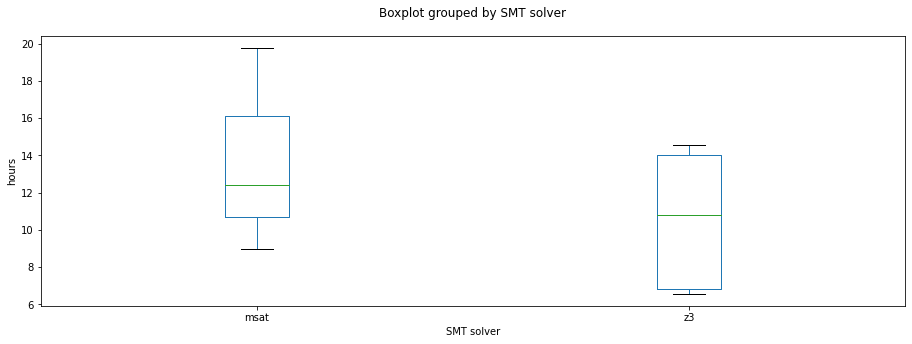

In [29]:
finish_time = datetime.timedelta(hours=6)

unfinshed = big_dataframe[(big_dataframe['incoming time'] + big_dataframe['outgoing time']) >= finish_time.total_seconds()]
unfinshed.insert(2, "total hours", [ (i+j)/3600 for i,j in zip(unfinshed['incoming time'], unfinshed['outgoing time'])])
unfinshed = unfinshed[['reference version', 'updated version', 'total hours', 'SMT solver']]

display(unfinshed.sort_values('SMT solver'))
axs = unfinshed.boxplot(by='SMT solver', grid=False, figsize=(15,5))
axs.set_ylabel("hours")
axs.set_xlabel("SMT solver")
axs.set_title("")
None

From this we can conclude that msat and z3 are not the best solver to scale to real-world problems. Here sometimes the time to get to a result is taking way to long.

## RQ2: Is one SMT solver superior to the other solvers?
In this question we will se if one solver performs way better on the models then any other model. Here we only take the finished execution as an input. This means that the unfinshed outcomes from RQ1 are not taken in to account. Also the executions for the same models of different solvers are not taking in account.\
To make the diferent execution time visable, a plot is created with the exection time of all SMT solvers against each other. In this way it becomes visable if one solver has a lower execution time then any other SMT-solver

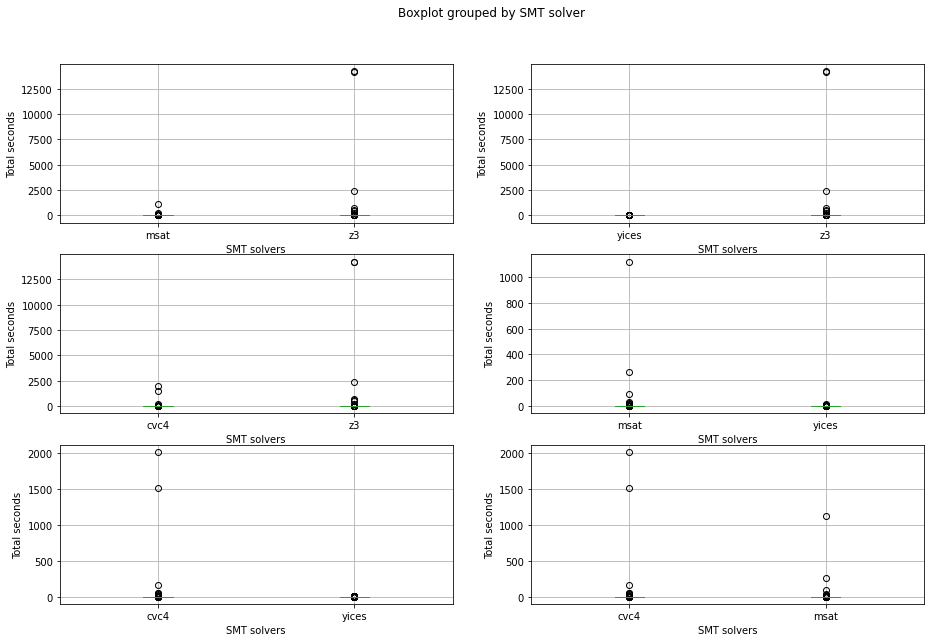

In [30]:
finshed_settings_frame = big_dataframe[(big_dataframe['incoming time'] + big_dataframe['outgoing time']) < finish_time.total_seconds()]
finshed_settings_frame.insert(3,"total seconds", [ (i+j) for i,j in zip(finshed_settings_frame['incoming time'], finshed_settings_frame['outgoing time'])])

average = finshed_settings_frame.groupby(["reference version", "updated version", "SMT solver"]).mean().reset_index()
sample_set = average[["reference version", "updated version", "SMT solver","total seconds"]]

sample_set.insert(2, "count", sample_set.groupby(["reference version", "updated version"])["SMT solver"].transform("count"))

only_finished = sample_set[sample_set["count"] == 4][["reference version", "updated version", "SMT solver","total seconds"]]

fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 10)

def show_finished_box_plot(solver1, solver2, ax):
    only_finished[(only_finished["SMT solver"] == solver1) | (only_finished["SMT solver"] == solver2)].boxplot(by="SMT solver", figsize=(15,5), ax=ax)
    ax.set_xlabel("SMT solvers")
    ax.set_ylabel("Total seconds")
    ax.set_title("")
    

show_finished_box_plot("z3", "msat", axes[0,0])
show_finished_box_plot("z3", "yices", axes[0,1])
show_finished_box_plot("z3", "cvc4", axes[1,0])

show_finished_box_plot("yices", "msat", axes[1,1])
show_finished_box_plot("yices", "cvc4", axes[2,0])

show_finished_box_plot("msat", "cvc4", axes[2,1])


In the plots we can see that yices is always much faster as any other solver. From this we can conclude that yices is much faster then any other solver. Since in every comparison yices is faster then its compatitor.

In [92]:
def wilcoxon(dataframe):
    return_list = []
    dataframe.insert(3,"total seconds", [ (i+j) for i,j in zip(dataframe['incoming time'], dataframe['outgoing time'])])
    z3_frame = dataframe[dataframe["SMT solver"] == "z3"]["total seconds"]
    yices_frame = dataframe[dataframe["SMT solver"] == "yices"]["total seconds"]
    msat_frame = dataframe[dataframe["SMT solver"] == "msat"]["total seconds"]
    cvc4_frame = dataframe[dataframe["SMT solver"] == "cvc4"]["total seconds"]
    return_list.append(stats.wilcoxon(z3_frame, yices_frame) + ("z3", "yices"))
    return_list.append(stats.wilcoxon(z3_frame, msat_frame) + ("z3", "msat"))
    return_list.append(stats.wilcoxon(z3_frame, cvc4_frame) + ("z3", "cvc4"))
    return_list.append(stats.wilcoxon(yices_frame, msat_frame) + ("yices", "msat"))
    return_list.append(stats.wilcoxon(yices_frame, cvc4_frame) + ("yices", "cvc4"))
    return_list.append(stats.wilcoxon(msat_frame, cvc4_frame) + ("msat", "cvc4"))
    return_frame = pandas.DataFrame(return_list)
    return_frame = return_frame.rename(columns={0: "T-value", 1: "p-value", 2: "SMT 1", 3: "SMT 2"})
    return return_frame


#Effect size (https://machinelearningmastery.com/effect-size-measures-in-python/)
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s


def effect_size(d):
    if d < 0:
        d = -1 * d
    if d < 0.2:
        return "Ignored"
    elif d < 0.5:
        return "Small"
    elif d < 0.8:
        return "Moderate"
    elif d < 1.4:
        return "Large"
    return "Very Large"

def effect_size_per_topic(dataframe):
    dataframe.insert(3,"total seconds", [ (i+j) for i,j in zip(dataframe['incoming time'], dataframe['outgoing time'])])
    z3_frame = dataframe[dataframe["SMT solver"] == "z3"]["total seconds"]
    yices_frame = dataframe[dataframe["SMT solver"] == "yices"]["total seconds"]
    msat_frame = dataframe[dataframe["SMT solver"] == "msat"]["total seconds"]
    cvc4_frame = dataframe[dataframe["SMT solver"] == "cvc4"]["total seconds"]
    
    effect_size_list = []
    effect_size_list.append({"SMT 1" : "z3", "SMT 2" : "yices", "Effect size" : cohend(z3_frame,yices_frame)})
    effect_size_list.append({"SMT 1" : "z3", "SMT 2" : "msat", "Effect size" : cohend(z3_frame,msat_frame)})
    effect_size_list.append({"SMT 1" : "z3", "SMT 2" : "cvc4", "Effect size" : cohend(z3_frame,cvc4_frame)})
    effect_size_list.append({"SMT 1" : "yices", "SMT 2" : "msat", "Effect size" : cohend(yices_frame,msat_frame)})
    effect_size_list.append({"SMT 1" : "yices", "SMT 2" : "cvc4", "Effect size" : cohend(yices_frame,cvc4_frame)})
    effect_size_list.append({"SMT 1" : "msat", "SMT 2" : "cvc4", "Effect size" : cohend(msat_frame,cvc4_frame)})

    effect_size_frame = pandas.DataFrame(effect_size_list)
    effect_size_frame.insert(2,"Relative size", [ effect_size(i) for i in effect_size_frame['Effect size'] ])
    return effect_size_frame


ssh_wilcoxon_result = wilcoxon(ssh_dataframe.copy())
ssh_wilcoxon_result.insert(0,"Topic", [ "SSH"  for i in ssh_wilcoxon_result['SMT 1']])
openssl_wilcoxon_result = wilcoxon(openssl_dataframe.copy())
openssl_wilcoxon_result.insert(0,"Topic", [ "OpenSSL"  for i in ssh_wilcoxon_result['SMT 1']])
tcp_wilcoxon_result = wilcoxon(tcp_dataframe.copy())
tcp_wilcoxon_result.insert(0,"Topic", [ "TCP"  for i in ssh_wilcoxon_result['SMT 1']])

wilcoxon_frame = pandas.concat([ssh_wilcoxon_result, openssl_wilcoxon_result, tcp_wilcoxon_result], join='inner')
wilcoxon_frame.insert(5,"Difference", [ "equal" if i > 0.05 else "not equal"  for i in wilcoxon_frame['p-value']])
display(wilcoxon_frame)

ssh_effect_size_frame = effect_size_per_topic(ssh_dataframe.copy())
ssh_effect_size_frame.insert(0,"Topic", [ "SSH"  for i in ssh_effect_size_frame['SMT 1']])
openssl_effect_size_frame = effect_size_per_topic(openssl_dataframe.copy())
openssl_effect_size_frame.insert(0,"Topic", [ "OpenSSL"  for i in openssl_effect_size_frame['SMT 1']])
tcp_effect_size_frame = effect_size_per_topic(tcp_dataframe.copy())
tcp_effect_size_frame.insert(0,"Topic", [ "TCP"  for i in ssh_effect_size_frame['SMT 1']])

effect_size_frame = pandas.concat([ssh_effect_size_frame, openssl_effect_size_frame, tcp_effect_size_frame])
display(effect_size_frame)

,Topic,T-value,p-value,SMT 1,SMT 2,Difference
0,SSH,36.0,5.790292e-16,z3,yices,not equal
1,SSH,1980.0,7.859304e-01,z3,msat,equal
2,SSH,608.0,6.951173e-09,z3,cvc4,not equal
3,SSH,22.0,3.639795e-16,yices,msat,not equal
4,SSH,0.0,1.743790e-16,yices,cvc4,not equal
5,SSH,0.0,1.743790e-16,msat,cvc4,not equal
0,OpenSSL,2280029.5,0.000000e+00,z3,yices,not equal
1,OpenSSL,3332356.0,0.000000e+00,z3,msat,not equal
2,OpenSSL,8167.0,0.000000e+00,z3,cvc4,not equal
3,OpenSSL,330313.5,0.000000e+00,yices,msat,not equal


,Topic,SMT 1,SMT 2,Relative size,Effect size
0,SSH,z3,yices,Small,0.458130
1,SSH,z3,msat,Ignored,0.155196
2,SSH,z3,cvc4,Ignored,-0.158415
3,SSH,yices,msat,Small,-0.430269
4,SSH,yices,cvc4,Moderate,-0.746909
5,SSH,msat,cvc4,Small,-0.366500
0,OpenSSL,z3,yices,Moderate,0.628628
1,OpenSSL,z3,msat,Moderate,-0.641393
2,OpenSSL,z3,cvc4,Very Large,-1.995171
3,OpenSSL,yices,msat,Large,-1.275568


## RQ3: Does the runtime of the solvers correlate to the size of the model changes?
In this question we take the outcome per different topic and check if the size of the input models has a corrolation with the execution time of the SMT solvers. Here we take the size of model changes as two different inputs. At first we take it as the number of total state pairs of the input models. As second we take it as the performance metrics. This then rolls out to the following questions:
- RQ3.1: Exection time vs number of state pairs
- RQ3.2: Execution time vs performance metrics

### RQ3.1: Exection time vs number of state pairs
In this subquestion we plot the execution time of the SMT solver against the number of states of the input and output model times each other. This we do for every topic we have.\
To see if the execution time is related to the number of state pairs we should be able to see a trend that when the product of the states is higher, the execution time is also higher.

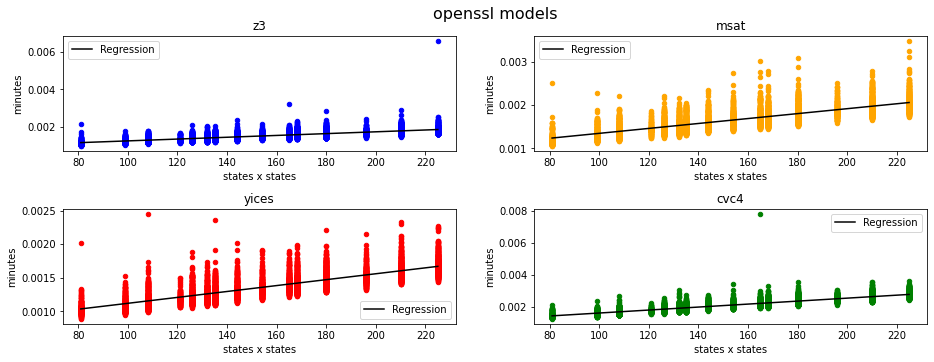

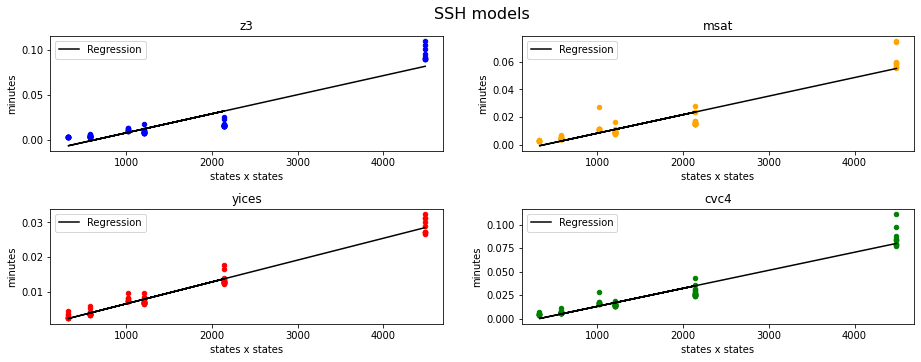

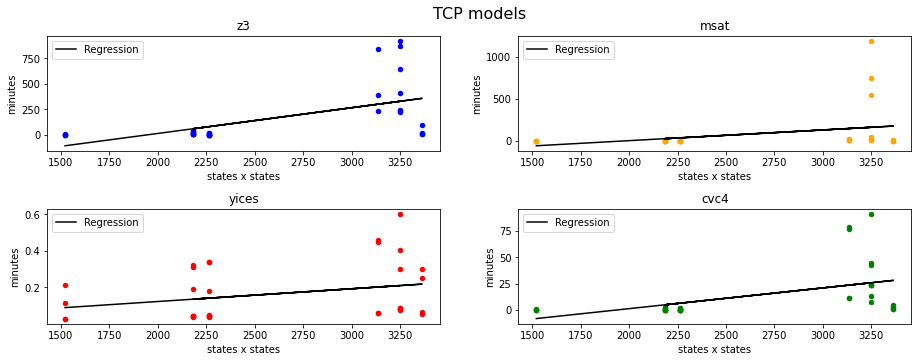

In [15]:
def exection_time_vs_state_pairs(dataframe, title):
    result_frame = dataframe[['SMT solver']]
    result_frame.insert(1,"states x states",[i*j for i,j in zip(dataframe['reference model: number of states'], dataframe['updated model: number of states'])])
    result_frame.insert(1,"minutes",[(i+j)/60 for i,j in zip(dataframe['incoming time'], dataframe['outgoing time'])])


    fig, axes = plt.subplots(nrows=2,ncols=2)
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(15, 5)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.5)
    for solver, ax, color in [("z3",axes[0,0], "blue"), ("msat", axes[0,1], "orange"), ("yices", axes[1,0], "red"), ("cvc4", axes[1,1], "green")]:
        temp_frame = result_frame[result_frame['SMT solver'] == solver]
        d = np.polyfit(temp_frame['states x states'],temp_frame["minutes"],1)
        f = np.poly1d(d)
        temp_frame.insert(0,'Regression',f(temp_frame['states x states']))
        temp_frame.plot.scatter("states x states", "minutes", c=color, subplots=True ,ax=ax)
        temp_frame.plot(x="states x states", y="Regression", color="black", subplots=True ,ax=ax)
        ax.set_title(solver)

    
  

    
exection_time_vs_state_pairs(openssl_dataframe, "openssl models")
exection_time_vs_state_pairs(ssh_dataframe, "SSH models")   
exection_time_vs_state_pairs(tcp_dataframe, "TCP models")   



As we can see in the plots, all the regression lines are positive linear. This shows that is some form of relation between the number of states and the execution time of the models. The trend is that, the higher the product is of input states. The longer it takes for the SMT solver to find a solution.

### RQ3.2: Execution time vs performance metrics
In this subquestion we plot the execution time of the SMT solver against the performance metrics. This performance metrics consits of the f-measure, precision and recall. We plot this for every topic we have.
To see if the execution time is related to the performance metrics we should be able to see a trend that the performance metrics is closer to 1, the execution time should be higher or lower then when it is not close to 1.

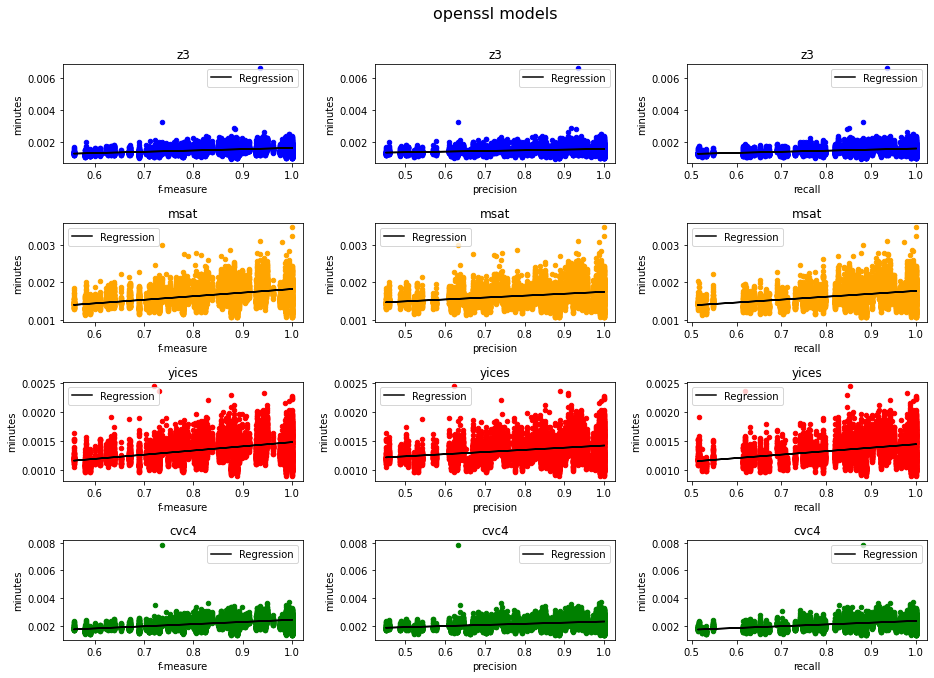

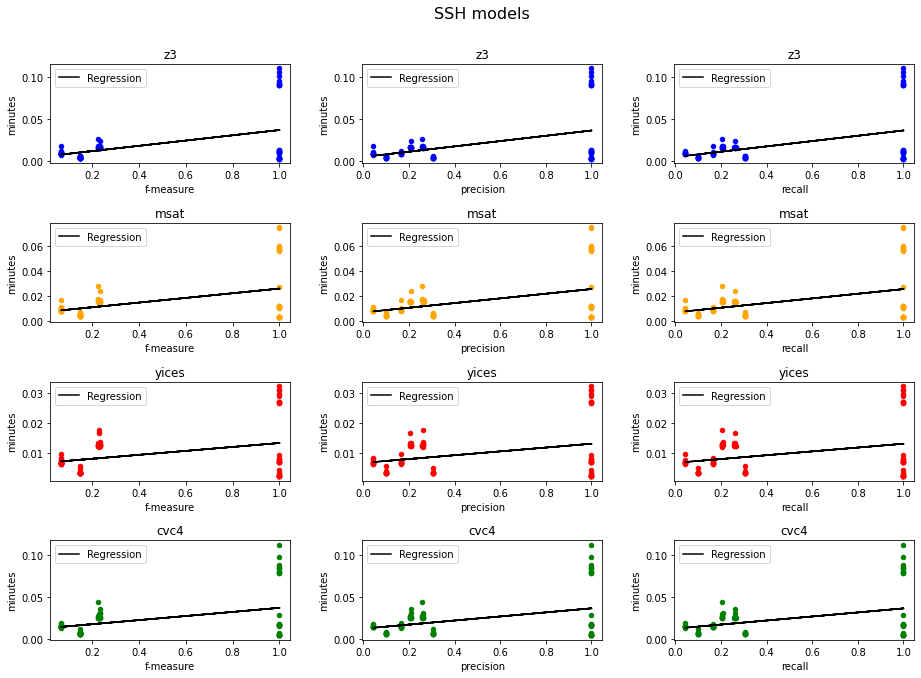

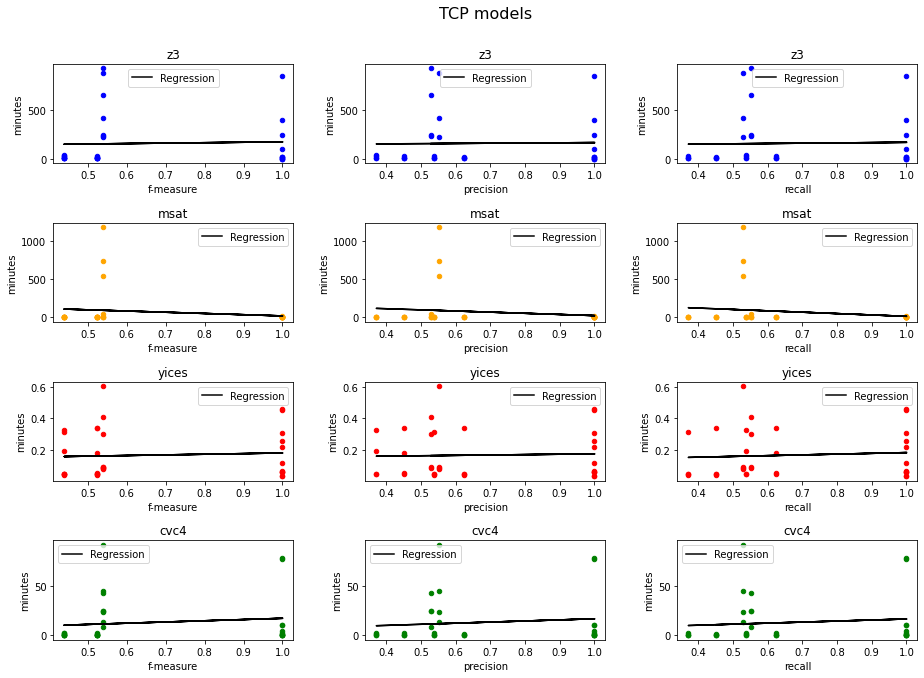

In [19]:
def draw_performance_time_plot(solver, color, row, dataframe, axes):
    temp_frame = dataframe[dataframe['SMT solver'] == solver]
    
    d = np.polyfit(temp_frame['f-measure'],temp_frame["minutes"],1)
    f = np.poly1d(d)
    temp_frame.insert(0,'Regression',f(temp_frame['f-measure']))
    temp_frame.plot.scatter("f-measure", "minutes", c=color, subplots=True ,ax=axes[row,0])
    temp_frame.plot(x="f-measure", y="Regression", color="black", subplots=True ,ax=axes[row,0])
    axes[row,0].set_title(solver)
    
    temp_frame = temp_frame[["precision", "recall", "minutes"]]
    d = np.polyfit(temp_frame['precision'],temp_frame["minutes"],1)
    f = np.poly1d(d)
    temp_frame.insert(0,'Regression',f(temp_frame['precision']))
    temp_frame.plot.scatter("precision", "minutes", c=color, subplots=True ,ax=axes[row,1])
    temp_frame.plot(x="precision", y="Regression", color="black", subplots=True ,ax=axes[row,1])
    axes[row,1].set_title(solver)
    
    temp_frame = temp_frame[["recall", "minutes"]]
    d = np.polyfit(temp_frame['recall'],temp_frame["minutes"],1)
    f = np.poly1d(d)
    temp_frame.insert(0,'Regression',f(temp_frame['recall']))
    temp_frame.plot.scatter("recall", "minutes", c=color, subplots=True ,ax=axes[row,2])
    temp_frame.plot(x="recall", y="Regression", color="black", subplots=True ,ax=axes[row,2])
    axes[row,2].set_title(solver)

def execution_time_vs_performance(dataframe, title):
    performance_frame = dataframe[['SMT solver', 'f-measure', 'precision', 'recall']]
    performance_frame.insert(1,"minutes",[(i+j)/60 for i,j in zip(dataframe['incoming time'], dataframe['outgoing time'])])


    fig, axes = plt.subplots(nrows=4,ncols=3)
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(15, 10)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.3, 
                        hspace=0.6)

    draw_performance_time_plot("z3", "blue", 0, performance_frame, axes)
    draw_performance_time_plot("msat", "orange", 1, performance_frame, axes)
    draw_performance_time_plot("yices", "red", 2, performance_frame, axes)
    draw_performance_time_plot("cvc4", "green", 3, performance_frame, axes)

execution_time_vs_performance(openssl_dataframe, "openssl models")
execution_time_vs_performance(ssh_dataframe, "SSH models")   
execution_time_vs_performance(tcp_dataframe, "TCP models")   



For the openSSL models and the SSH models we see a trend that when the f-measure, recall and precision are closer to 1. The execution time is higher. While for the TCP models, we don't see this trend happening. Therefore it is not good to say if this holds for every case.

## RQ4: How does the difference between models change during the evolution of a system?
In this question we take close look at the openSSL models. Here we check how much changes there are over the evolution of a system. More specific, we compare the release date of the model against the performance metrics. The performance metrics gives as result a value from 0 to 1 where how closer the model is to 1, how more similar the models are.\
As the models are changing over the years, you expect that there older systems are less equal then newer systems.

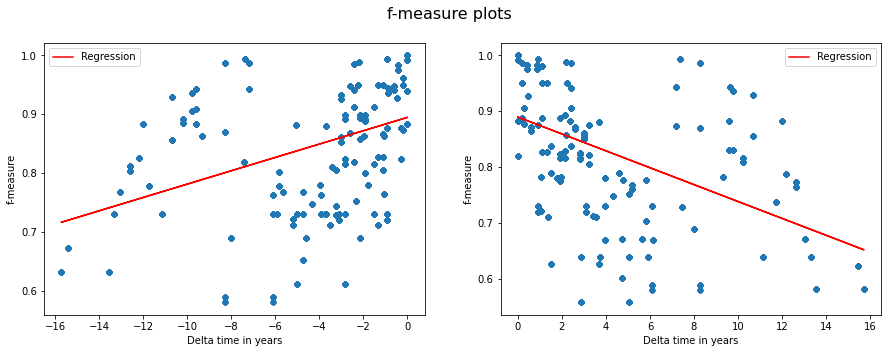

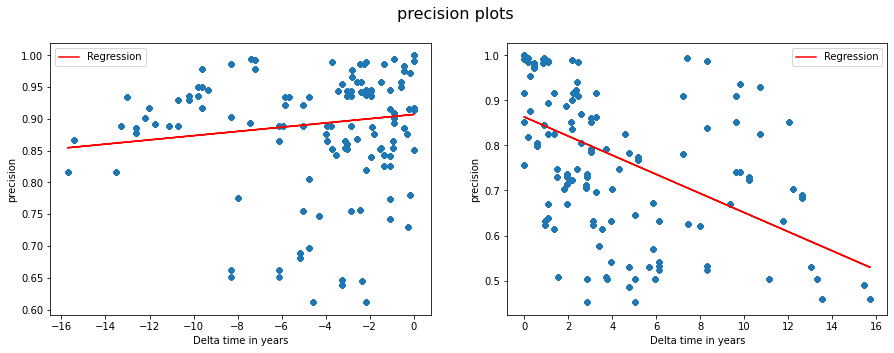

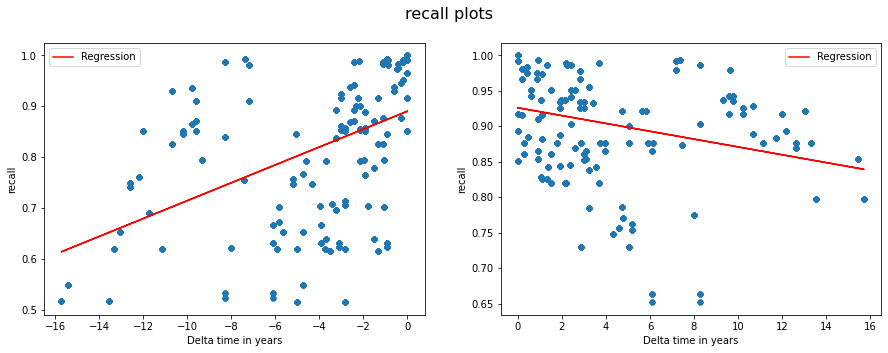

In [21]:
openssl_evolution = openssl_dataframe[openssl_dataframe['SMT solver'] == 'yices']
openssl_evolution.insert(0,'years', [ i/365 for i in openssl_evolution['delta date (days)']])
openssl_evolution = openssl_evolution[['years', 'f-measure', 'precision', 'recall']]


def plot_regression(y_value):
    
    negative = openssl_evolution[openssl_evolution['years'] <= 0]
    positive = openssl_evolution[openssl_evolution['years'] >= 0]

    d = np.polyfit(negative['years'],negative[y_value],1)
    f = np.poly1d(d)
    negative.insert(0,'Regression',f(negative['years']))

    d = np.polyfit(positive['years'],positive[y_value],1)
    f = np.poly1d(d)
    positive.insert(0,'Regression',f(positive['years']))

    fig, axes = plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(15, 5)
    fig.suptitle(y_value + " plots", fontsize=16)
    
    negative.plot.scatter('years', y_value, ax=axes[0], subplots=True)
    negative.plot(x='years', y='Regression',color='Red',ax=axes[0])
    axes[0].set_xlabel("Delta time in years")

    axs = positive.plot.scatter('years', y_value, ax=axes[1], subplots=True)
    positive.plot(x='years', y='Regression',color='Red',ax=axes[1])
    axes[1].set_xlabel("Delta time in years")

plot_regression('f-measure')
plot_regression('precision')
plot_regression('recall')

As we can see it is indeed the case that over time the models are less similar.